#### Install some packages used in this notebook

In [ ]:
pip install kmodes pyclustering lshkrepresentatives xlsxwriter

#### Performance comparison on Soybean small dataset

In [11]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from MGR_algo import mgr
from EGA_FMC_algo import ega_fmc
from MIS_algo import clustering
from LSHkRepresentatives.LSHkRepresentatives import LSHkRepresentatives
from MFKmeans_algo import mfk
from pyclustering.cluster.rock import rock
from Fuzzy_Kmodes_algo import fuzzy_kmodes
from Shapley_cat_algo import shapley_cat
from Krepresentatives_algo import KRepresentatives
from Kmeans_like_algo import kmeans_like
from KPbC_algo import k_PbC_clustering
import evaluation
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset
dataset = "datasets/soybean.csv"
data = np.genfromtxt(dataset, delimiter=',', encoding='utf-8', dtype='str')
x = data[:, :-1]
y = data[:, -1]

k = 4
x_df = pd.DataFrame(x)

# Function to run a single round of clustering with a specified algorithm
def run_clustering_algorithm(algo_name):
    if algo_name == 'KModes_Huang':
        model = KModes(n_clusters=k, init='Huang', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'KModes_Cao': # Cao, F., Liang, J., Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.
        model = KModes(n_clusters=k, init='Cao', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'MGR':
        labels = mgr(x_df, k)
    elif algo_name == 'EGA_FMC':
        labels = ega_fmc(x, k)
    elif algo_name == 'MIS':
        _, labels, _, _ = clustering(x_df, k)
        labels = labels.astype(int)
    elif algo_name == 'LSH_kReps':
        kreps = LSHkRepresentatives(n_clusters=k, n_init=5)
        labels = kreps.fit(x)
    elif algo_name == 'MFKmeans':
        labels = mfk(x, k)
    elif algo_name == 'ROCK':
        rock_instance = rock(x_df.to_numpy(dtype=int), eps=4, number_clusters=k)
        rock_instance.process()
        clusters = rock_instance.get_clusters()
        labels = [-1] * len(x)
        for cluster_label, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_label
        labels = np.array(labels)
    elif algo_name == 'Fuzzy_Kmodes':
        _, _, labels, _ = fuzzy_kmodes(X=x, initialCluster=[], n_clusters=k)
        labels -= 1
    elif algo_name == 'GT_Kmodes':
        data, cl_bigc, _ = shapley_cat(x_df, delta=0.5, P=x_df.shape[0])
        cl_bigc = cl_bigc[0:k]
        model = KModes(n_clusters=k, init=np.array(cl_bigc), n_init=100, verbose=0)
        labels = model.fit_predict(data)
    elif algo_name == 'K_representatives':
        model = KRepresentatives(n_clusters=k, init='random', n_init=100, verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'K_means_like':
        labels = kmeans_like(x, n_clusters=k, init='random', n_init=10, verbose=0, use_global_attr_count=0, beta=8)
    elif algo_name == 'K_PbC':
        labels = k_PbC_clustering(x_df=x_df, k=k, min_support=0.4)
    else:
        raise ValueError("Algorithm not recognized.")
    
    return labels

# Metrics calculation
def calculate_metrics(labels, true_labels):
    accuracy = evaluation.accuracy(labels, true_labels)
    purity = evaluation.purity(labels, true_labels)
    ari = evaluation.rand(labels, true_labels)
    nmi = evaluation.nmi(labels, true_labels)
    return accuracy, purity, ari, nmi

# Run 100 rounds for each algorithm
algorithms = ['KModes_Huang', 'Fuzzy_Kmodes', 'ROCK', 'K_representatives',
              'KModes_Cao', 'MGR', 'MFKmeans', 
              'K_means_like', 'K_PbC', 'LSH_kReps', 'GT_Kmodes', 'MIS']

# Dictionary to store mean metrics for each algorithm
average_metrics = {}

for algo in algorithms:
    print(f"Processing {algo}...")
    results = []
    
    for _ in tqdm(range(100), desc=f'Running {algo}'):
        labels = run_clustering_algorithm(algo)
        metrics = calculate_metrics(labels, y)
        results.append(metrics)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=['Accuracy', 'Purity', 'ARI', 'NMI'])
    
    # Calculate mean and std
    mean_values = results_df.mean()
    std_values = results_df.std()

    # Save the mean metrics
    average_metrics[algo] = mean_values

    # Print the results in table format
    print("\nResults:")
    print(pd.DataFrame({
        'Metric': ['Accuracy', 'Purity', 'ARI', 'NMI'],
        'Average': mean_values.values,
        'Std': std_values.values
    }).to_string(index=False))

    # Save to Excel
    filename = f"_output_Soybean/Algo_{algo}.xlsx"
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        
        workbook  = writer.book
        worksheet = writer.sheets['Results']
        
        # Write Average and Std
        worksheet.write(len(results_df) + 1, 0, 'Average:')
        worksheet.write_row(len(results_df) + 2, 0, mean_values.values)
        
        worksheet.write(len(results_df) + 4, 0, 'Std:')
        worksheet.write_row(len(results_df) + 5, 0, std_values.values)

    print(f"Results saved to {filename}\n")


# Algorithm names
algo_names = [
    "K-modes Huang (1998)", "Fuzzy K-modes (1999)", "ROCK (2000)", 
    "K-representatives (2004)", "K-modes Cao (2009)", 
    "Genetic Fuzzy K-modes (2009)", "MGR (2014)", "EGA FMC (2018)", 
    "MFK-means (2018)", "K-means like (2019)", "K-PbC (2020)", 
    "LSH K-representatives (2021)", "GT-Kmodes (2021)", "MIS (2022)"
]

# Prepare DataFrame to hold the average metrics
average_metrics_df = pd.DataFrame(index=algo_names, columns=["Accuracy", "Purity", "ARI", "NMI"])

# Populate the DataFrame with available metrics
average_metrics_df.loc["K-modes Huang (1998)"] = average_metrics.get('KModes_Huang', [""] * 4)
average_metrics_df.loc["Fuzzy K-modes (1999)"] = average_metrics.get('Fuzzy_Kmodes', [""] * 4)
average_metrics_df.loc["ROCK (2000)"] = average_metrics.get('ROCK', [""] * 4)
average_metrics_df.loc["K-representatives (2004)"] = average_metrics.get('K_representatives', [""] * 4)
average_metrics_df.loc["K-modes Cao (2009)"] = average_metrics.get('KModes_Cao', [""] * 4)
average_metrics_df.loc["Genetic Fuzzy K-modes (2009)"] = [""] * 4
average_metrics_df.loc["MGR (2014)"] = average_metrics.get('MGR', [""] * 4)
average_metrics_df.loc["EGA FMC (2018)"] = [""] * 4
average_metrics_df.loc["MFK-means (2018)"] = average_metrics.get('MFKmeans', [""] * 4)
average_metrics_df.loc["K-means like (2019)"] = average_metrics.get('K_means_like', [""] * 4)
average_metrics_df.loc["K-PbC (2020)"] = average_metrics.get('K_PbC', [""] * 4)
average_metrics_df.loc["LSH K-representatives (2021)"] = average_metrics.get('LSH_kReps', [""] * 4)
average_metrics_df.loc["GT-Kmodes (2021)"] = average_metrics.get('GT_Kmodes', [""] * 4)
average_metrics_df.loc["MIS (2022)"] = average_metrics.get('MIS', [""] * 4)

# Save to CSV
output_csv = "_output_Soybean/average_metrics_all_algorithms.csv"
average_metrics_df.to_csv(output_csv, index=True)

print(f"Average metrics of all algorithms saved to {output_csv}")

Processing KModes_Huang...


Running KModes_Huang: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]



Results:
  Metric  Average      Std
Accuracy 0.985106 0.023908
  Purity 0.985106 0.023908
     ARI 0.957343 0.061844
     NMI 0.967293 0.043516
Results saved to _output_Soybean/Algo_KModes_Huang.xlsx

Processing Fuzzy_Kmodes...


Running Fuzzy_Kmodes: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]



Results:
  Metric  Average      Std
Accuracy 0.755319 0.141828
  Purity 0.823191 0.099874
     ARI 0.646019 0.190234
     NMI 0.772746 0.136087
Results saved to _output_Soybean/Algo_Fuzzy_Kmodes.xlsx

Processing ROCK...


Running ROCK: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]



Results:
  Metric  Average          Std
Accuracy 0.829787 2.231632e-16
  Purity 0.829787 2.231632e-16
     ARI 0.673790 2.231632e-16
     NMI 0.822924 2.231632e-16
Results saved to _output_Soybean/Algo_ROCK.xlsx

Processing K_representatives...


Running K_representatives: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]



Results:
  Metric  Average      Std
Accuracy 0.870000 0.156055
  Purity 0.907660 0.110669
     ARI 0.835461 0.198090
     NMI 0.905429 0.114320
Results saved to _output_Soybean/Algo_K_representatives.xlsx

Processing KModes_Cao...


Running KModes_Cao: 100%|██████████| 100/100 [00:03<00:00, 33.32it/s]



Results:
  Metric  Average  Std
Accuracy      1.0  0.0
  Purity      1.0  0.0
     ARI      1.0  0.0
     NMI      1.0  0.0
Results saved to _output_Soybean/Algo_KModes_Cao.xlsx

Processing MGR...


Running MGR: 100%|██████████| 100/100 [08:46<00:00,  5.26s/it]



Results:
  Metric  Average          Std
Accuracy 0.829787 2.231632e-16
  Purity 0.829787 2.231632e-16
     ARI 0.673790 2.231632e-16
     NMI 0.822924 4.463264e-16
Results saved to _output_Soybean/Algo_MGR.xlsx

Processing MFKmeans...


Running MFKmeans: 100%|██████████| 100/100 [00:01<00:00, 57.08it/s]



Results:
  Metric  Average      Std
Accuracy 0.857234 0.147851
  Purity 0.883617 0.116319
     ARI 0.778859 0.214673
     NMI 0.866448 0.133603
Results saved to _output_Soybean/Algo_MFKmeans.xlsx

Processing K_means_like...


Running K_means_like: 100%|██████████| 100/100 [05:20<00:00,  3.21s/it]



Results:
  Metric  Average          Std
Accuracy      1.0 0.000000e+00
  Purity      1.0 0.000000e+00
     ARI      1.0 0.000000e+00
     NMI      1.0 2.231632e-16
Results saved to _output_Soybean/Algo_K_means_like.xlsx

Processing K_PbC...


Running K_PbC: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]



Results:
  Metric  Average  Std
Accuracy      1.0  0.0
  Purity      1.0  0.0
     ARI      1.0  0.0
     NMI      1.0  0.0
Results saved to _output_Soybean/Algo_K_PbC.xlsx

Processing LSH_kReps...


Running LSH_kReps: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]



Results:
  Metric  Average  Std
Accuracy      1.0  0.0
  Purity      1.0  0.0
     ARI      1.0  0.0
     NMI      1.0  0.0
Results saved to _output_Soybean/Algo_LSH_kReps.xlsx

Processing GT_Kmodes...


Running GT_Kmodes: 100%|██████████| 100/100 [00:06<00:00, 15.76it/s]



Results:
  Metric  Average  Std
Accuracy      1.0  0.0
  Purity      1.0  0.0
     ARI      1.0  0.0
     NMI      1.0  0.0
Results saved to _output_Soybean/Algo_GT_Kmodes.xlsx

Processing MIS...


Running MIS: 100%|██████████| 100/100 [09:55<00:00,  5.95s/it]


Results:
  Metric  Average          Std
Accuracy 0.680851 1.115816e-16
  Purity 0.787234 1.115816e-16
     ARI 0.592411 1.115816e-16
     NMI 0.787854 0.000000e+00
Results saved to _output_Soybean/Algo_MIS.xlsx

Average metrics of all algorithms saved to _output_Soybean/average_metrics_all_algorithms.csv


### Draw the bar chart for performance comparison on Soybean dataset

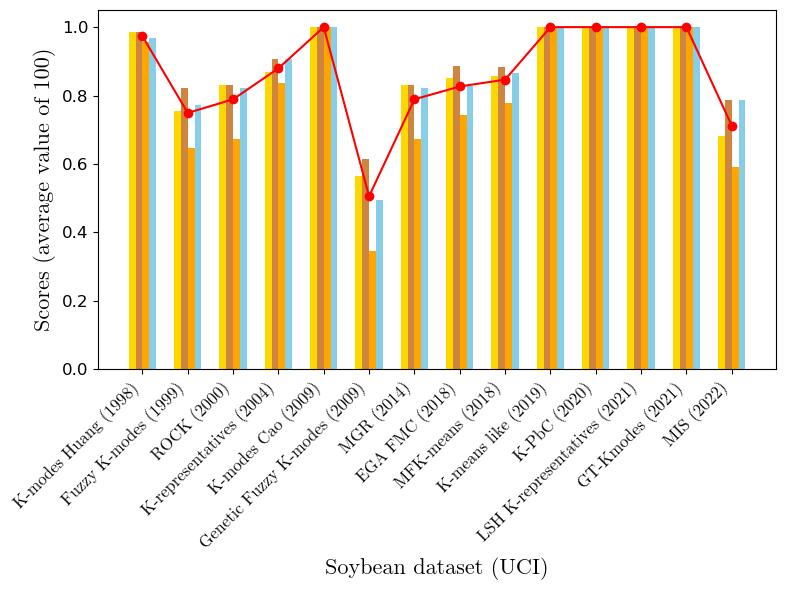

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Path to your font file
font_path = 'lmroman10-regular.otf'
font_prop = font_manager.FontProperties(fname=font_path)

# Define a larger font size for various elements
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
bar_label_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Read the data from CSV
df = pd.read_csv('_output_Soybean/average_metrics_all_algorithms.csv')

# Extract algorithms and metrics
algorithms = df.iloc[:, 0].tolist()  # The first column contains the algorithm names
metrics = df.columns[1:].tolist()    # The rest of the columns are metrics

# Extract values (skip the first column which is the algorithm names)
values = df.iloc[:, 1:].values

# Calculate the average of the four metrics for each algorithm
averages = values.mean(axis=1)

# Set up bar plot
x = np.arange(len(algorithms))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['gold', 'peru', 'orange', 'skyblue']  # Colors for each metric

# Create bars for each metric
bars = []
for i in range(len(metrics)):
    bar = ax.bar(x + i * width, values[:, i], width, label=metrics[i], color=colors[i])
    bars.append(bar)

# Add line plot for the average values
# Adjust the x positions so that the average line passes between the second and third bars
average_x_positions = x + 1.5 * width
ax.plot(average_x_positions, averages, color='red', marker='o', linestyle='-', label='Average Score')

# Set labels and ticks
ax.set_ylabel('Scores (average value of 100)', fontproperties=large_font_prop)
ax.set_xlabel('Soybean dataset (UCI)', fontproperties=large_font_prop)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(algorithms, fontproperties=bar_label_font_prop, rotation=45, ha="right")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add legend
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5, prop=large_font_prop)

# Adjust layout
fig.tight_layout()

# Save the plot as PDF with high quality
plt.savefig('clustering_performances_soybean.pdf', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

#### Performance comparison on Zoo dataset

In [9]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from MGR_algo import mgr
from EGA_FMC_algo import ega_fmc
from MIS_algo import clustering
from LSHkRepresentatives.LSHkRepresentatives import LSHkRepresentatives
from MFKmeans_algo import mfk
from pyclustering.cluster.rock import rock
from Fuzzy_Kmodes_algo import fuzzy_kmodes
from Shapley_cat_algo import shapley_cat
from Krepresentatives_algo import KRepresentatives
from Kmeans_like_algo import kmeans_like
from KPbC_algo import k_PbC_clustering
import evaluation
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Load dataset
dataset = "datasets/zoo.csv"
data = np.genfromtxt(dataset, delimiter=',', encoding='utf-8', dtype='str')
x = data[:, :-1]
y = data[:, -1]

k = 7
x_df = pd.DataFrame(x)

# Function to run a single round of clustering with a specified algorithm
def run_clustering_algorithm(algo_name):
    if algo_name == 'KModes_Huang':
        model = KModes(n_clusters=k, init='Huang', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'KModes_Cao': # Cao, F., Liang, J., Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.
        model = KModes(n_clusters=k, init='Cao', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'MGR':
        labels = mgr(x_df, k)
    elif algo_name == 'EGA_FMC':
        labels = ega_fmc(x, k)
    elif algo_name == 'MIS':
        _, labels, _, _ = clustering(x_df, k)
        labels = labels.astype(int)
    elif algo_name == 'LSH_kReps':
        kreps = LSHkRepresentatives(n_clusters=k, n_init=5)
        labels = kreps.fit(x)
    elif algo_name == 'MFKmeans':
        labels = mfk(x, k)
    elif algo_name == 'ROCK':
        rock_instance = rock(x_df.to_numpy(dtype=int), eps=4, number_clusters=k)
        rock_instance.process()
        clusters = rock_instance.get_clusters()
        labels = [-1] * len(x)
        for cluster_label, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_label
        labels = np.array(labels)
    elif algo_name == 'Fuzzy_Kmodes':
        _, _, labels, _ = fuzzy_kmodes(X=x, initialCluster=[], n_clusters=k)
        labels -= 1
    elif algo_name == 'GT_Kmodes':
        data, cl_bigc, _ = shapley_cat(x_df, delta=0.7, P=x_df.shape[0])
        cl_bigc = cl_bigc[0:k]
        model = KModes(n_clusters=k, init=np.array(cl_bigc), n_init=100, verbose=0)
        labels = model.fit_predict(data)
    elif algo_name == 'K_representatives':
        model = KRepresentatives(n_clusters=k, init='random', n_init=100, verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'K_means_like':
        labels = kmeans_like(x, n_clusters=k, init='random', n_init=10, verbose=0, use_global_attr_count=0, beta=8)
    elif algo_name == 'K_PbC':
        labels = k_PbC_clustering(x_df=x_df, k=k, min_support=0.05)
    else:
        raise ValueError("Algorithm not recognized.")
    
    return labels

# Metrics calculation
def calculate_metrics(labels, true_labels):
    accuracy = evaluation.accuracy(labels, true_labels)
    purity = evaluation.purity(labels, true_labels)
    ari = evaluation.rand(labels, true_labels)
    nmi = evaluation.nmi(labels, true_labels)
    return accuracy, purity, ari, nmi

# Run 100 rounds for each algorithm
algorithms = ['KModes_Huang', 'Fuzzy_Kmodes', 'ROCK', 'K_representatives',
              'KModes_Cao', 'MGR', 'MFKmeans', 'K_means_like', 'K_PbC', 'LSH_kReps', 'GT_Kmodes', 'MIS']

# Dictionary to store mean metrics for each algorithm
average_metrics = {}

for algo in algorithms:
    print(f"Processing {algo}...")
    results = []
    
    for _ in tqdm(range(100), desc=f'Running {algo}'):
        labels = run_clustering_algorithm(algo)
        metrics = calculate_metrics(labels, y)
        results.append(metrics)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=['Accuracy', 'Purity', 'ARI', 'NMI'])
    
    # Calculate mean and std
    mean_values = results_df.mean()
    std_values = results_df.std()

    # Save the mean metrics
    average_metrics[algo] = mean_values

    # Print the results in table format
    print("\nResults:")
    print(pd.DataFrame({
        'Metric': ['Accuracy', 'Purity', 'ARI', 'NMI'],
        'Average': mean_values.values,
        'Std': std_values.values
    }).to_string(index=False))

    # Save to Excel
    filename = f"_output_Zoo/Algo_{algo}.xlsx"
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        
        workbook  = writer.book
        worksheet = writer.sheets['Results']
        
        # Write Average and Std
        worksheet.write(len(results_df) + 1, 0, 'Average:')
        worksheet.write_row(len(results_df) + 2, 0, mean_values.values)
        
        worksheet.write(len(results_df) + 4, 0, 'Std:')
        worksheet.write_row(len(results_df) + 5, 0, std_values.values)

    print(f"Results saved to {filename}\n")

# Save average metrics to a CSV file
algo_names = ["K-modes Huang (1998)", "Fuzzy K-modes (1999)", "ROCK (2000)", "K-representatives (2004)",
              "K-modes Cao (2009)", "Genetic Fuzzy K-modes (2009)", "MGR (2014)", "EGA FMC (2018)", 
              "MFK-means (2018)", "K-means like (2019)", "K-PbC (2020)", "LSH K-representatives (2021)", 
              "GT-Kmodes (2021)", "MIS (2022)"]

# Prepare DataFrame with empty values for "Genetic Fuzzy K-modes (2009)"
average_metrics_df = pd.DataFrame(index=algo_names, columns=["Accuracy", "Purity", "ARI", "NMI"])

for algo, mean_values in average_metrics.items():
    algo_name = algo.replace('_', '-')
    average_metrics_df.loc[algo_name] = mean_values

# Set empty values for "Genetic Fuzzy K-modes (2009)" and "EGA FMC (2018)"
average_metrics_df.loc["Genetic Fuzzy K-modes (2009)"] = [""] * 4
average_metrics_df.loc["EGA FMC (2018)"] = [""] * 4

# Save to CSV
output_csv = "_output_Zoo/average_metrics_all_algorithms.csv"
average_metrics_df.to_csv(output_csv, index=True)

print(f"Average metrics of all algorithms saved to {output_csv}")

Processing KModes_Huang...


Running KModes_Huang: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]



Results:
  Metric  Average      Std
Accuracy 0.721188 0.076676
  Purity 0.892178 0.024370
     ARI 0.652927 0.095065
     NMI 0.797171 0.043530
Results saved to _output_Zoo/Algo_KModes_Huang.xlsx

Processing Fuzzy_Kmodes...


Running Fuzzy_Kmodes: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]



Results:
  Metric  Average      Std
Accuracy 0.675941 0.101829
  Purity 0.838317 0.042570
     ARI 0.619566 0.137321
     NMI 0.752977 0.062449
Results saved to _output_Zoo/Algo_Fuzzy_Kmodes.xlsx

Processing ROCK...


Running ROCK: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]



Results:
  Metric  Average          Std
Accuracy 0.415842 5.579081e-17
  Purity 0.455446 1.673724e-16
     ARI 0.027717 6.973851e-18
     NMI 0.123820 5.579081e-17
Results saved to _output_Zoo/Algo_ROCK.xlsx

Processing K_representatives...


Running K_representatives: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]



Results:
  Metric  Average      Std
Accuracy 0.722970 0.089999
  Purity 0.867129 0.032556
     ARI 0.664282 0.112717
     NMI 0.793765 0.038884
Results saved to _output_Zoo/Algo_K_representatives.xlsx

Processing KModes_Cao...


Running KModes_Cao: 100%|██████████| 100/100 [00:04<00:00, 20.28it/s]



Results:
  Metric  Average          Std
Accuracy 0.673267 3.347448e-16
  Purity 0.881188 1.115816e-16
     ARI 0.588353 1.115816e-16
     NMI 0.763457 0.000000e+00
Results saved to _output_Zoo/Algo_KModes_Cao.xlsx

Processing MGR...


Running MGR: 100%|██████████| 100/100 [06:39<00:00,  4.00s/it]



Results:
  Metric  Average          Std
Accuracy 0.910891 3.347448e-16
  Purity 0.920792 3.347448e-16
     ARI 0.955541 0.000000e+00
     NMI 0.930147 2.231632e-16
Results saved to _output_Zoo/Algo_MGR.xlsx

Processing MFKmeans...


Running MFKmeans: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]



Results:
  Metric  Average      Std
Accuracy 0.771386 0.064213
  Purity 0.850000 0.031353
     ARI 0.668561 0.100892
     NMI 0.776935 0.048563
Results saved to _output_Zoo/Algo_MFKmeans.xlsx

Processing K_means_like...


Running K_means_like: 100%|██████████| 100/100 [14:38<00:00,  8.79s/it]



Results:
  Metric  Average          Std
Accuracy 0.841584 0.000000e+00
  Purity 0.930693 0.000000e+00
     ARI 0.778064 4.463264e-16
     NMI 0.860129 3.347448e-16
Results saved to _output_Zoo/Algo_K_means_like.xlsx

Processing K_PbC...


Running K_PbC: 100%|██████████| 100/100 [01:33<00:00,  1.06it/s]



Results:
  Metric  Average          Std
Accuracy 0.831683 1.115816e-16
  Purity 0.881188 1.115816e-16
     ARI 0.793100 2.231632e-16
     NMI 0.836320 0.000000e+00
Results saved to _output_Zoo/Algo_K_PbC.xlsx

Processing LSH_kReps...


Running LSH_kReps: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]



Results:
  Metric  Average          Std
Accuracy 0.772277 2.231632e-16
  Purity 0.891089 1.115816e-16
     ARI 0.679340 1.115816e-16
     NMI 0.796759 1.115816e-16
Results saved to _output_Zoo/Algo_LSH_kReps.xlsx

Processing GT_Kmodes...


Running GT_Kmodes: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]



Results:
  Metric  Average          Std
Accuracy 0.801980 1.115816e-16
  Purity 0.861386 2.231632e-16
     ARI 0.804623 2.231632e-16
     NMI 0.849749 2.231632e-16
Results saved to _output_Zoo/Algo_GT_Kmodes.xlsx

Processing MIS...


Running MIS: 100%|██████████| 100/100 [04:57<00:00,  2.97s/it]


Results:
  Metric  Average          Std
Accuracy 0.841584 0.000000e+00
  Purity 0.891089 1.115816e-16
     ARI 0.901179 1.115816e-16
     NMI 0.881109 2.231632e-16
Results saved to _output_Zoo/Algo_MIS.xlsx

Average metrics of all algorithms saved to _output_Zoo/average_metrics_all_algorithms.csv


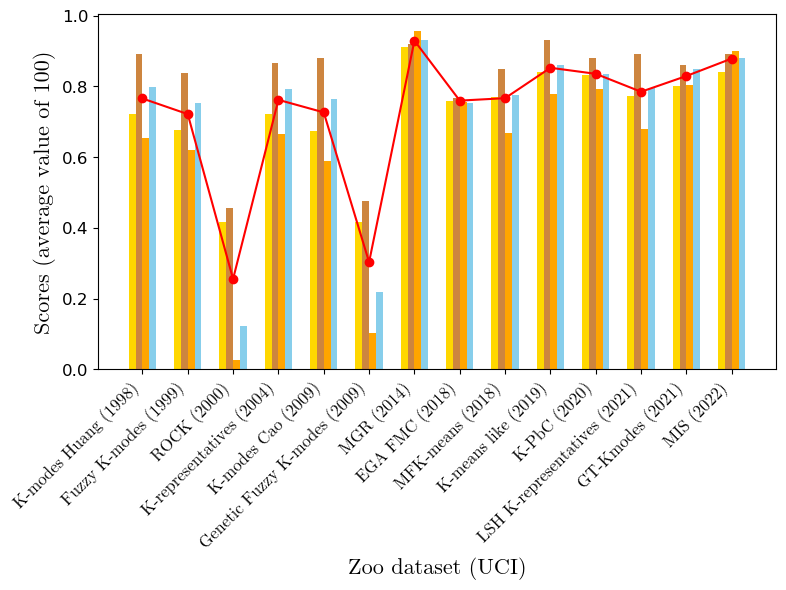

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Path to your font file
font_path = 'lmroman10-regular.otf'
font_prop = font_manager.FontProperties(fname=font_path)

# Define a larger font size for various elements
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
bar_label_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Read the data from CSV
df = pd.read_csv('_output_Zoo/average_metrics_all_algorithms.csv')

# Extract algorithms and metrics
algorithms = df.iloc[:, 0].tolist()  # The first column contains the algorithm names
metrics = df.columns[1:].tolist()    # The rest of the columns are metrics

# Extract values (skip the first column which is the algorithm names)
values = df.iloc[:, 1:].values

# Calculate the average of the four metrics for each algorithm
averages = values.mean(axis=1)

# Set up bar plot
x = np.arange(len(algorithms))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['gold', 'peru', 'orange', 'skyblue']  # Colors for each metric

# Create bars for each metric
bars = []
for i in range(len(metrics)):
    bar = ax.bar(x + i * width, values[:, i], width, label=metrics[i], color=colors[i])
    bars.append(bar)

# Add line plot for the average values
# Adjust the x positions so that the average line passes between the second and third bars
average_x_positions = x + 1.5 * width
ax.plot(average_x_positions, averages, color='red', marker='o', linestyle='-', label='Average Score')

# Set labels and ticks
ax.set_ylabel('Scores (average value of 100)', fontproperties=large_font_prop)
ax.set_xlabel('Zoo dataset (UCI)', fontproperties=large_font_prop)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(algorithms, fontproperties=bar_label_font_prop, rotation=45, ha="right")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add legend
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5, prop=large_font_prop)

# Adjust layout
fig.tight_layout()

# Save the plot as PDF with high quality
plt.savefig('clustering_performances_zoo.pdf', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

#### Performance comparison on Voting dataset

In [9]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from MGR_algo import mgr
from EGA_FMC_algo import ega_fmc
from MIS_algo import clustering
from LSHkRepresentatives.LSHkRepresentatives import LSHkRepresentatives
from MFKmeans_algo import mfk
from pyclustering.cluster.rock import rock
from Fuzzy_Kmodes_algo import fuzzy_kmodes
from Shapley_cat_algo import shapley_cat
from Krepresentatives_algo import KRepresentatives
from Kmeans_like_algo import kmeans_like
from KPbC_algo import k_PbC_clustering
import evaluation
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Load dataset
data = np.genfromtxt("datasets/congressional_voting_records.csv", delimiter=',', encoding='utf-8-sig', dtype='str')
x = data[:, :-1]
y = data[:, -1]
k = 2
x_df = pd.DataFrame(x)

# Function to run a single round of clustering with a specified algorithm
def run_clustering_algorithm(algo_name):
    if algo_name == 'KModes_Huang':
        model = KModes(n_clusters=k, init='Huang', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'KModes_Cao': # Cao, F., Liang, J., Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.
        model = KModes(n_clusters=k, init='Cao', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'MGR':
        labels = mgr(x_df, k)
    elif algo_name == 'EGA_FMC':
        labels = ega_fmc(x, k)
    elif algo_name == 'MIS':
        _, labels, _, _ = clustering(x_df, k)
        labels = labels.astype(int)
    elif algo_name == 'LSH_kReps':
        kreps = LSHkRepresentatives(n_clusters=k, n_init=5)
        labels = kreps.fit(x)
    elif algo_name == 'MFKmeans':
        labels = mfk(x, k)
    elif algo_name == 'ROCK':
        le = LabelEncoder()
        x_encoded = x_df.apply(le.fit_transform)
        rock_instance = rock(x_encoded.to_numpy(dtype=int), eps=4, number_clusters=k)
        rock_instance.process()
        clusters = rock_instance.get_clusters()
        labels = [-1] * len(x_encoded)
        for cluster_label, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_label
        labels = np.array(labels)
    elif algo_name == 'Fuzzy_Kmodes':
        _, _, labels, _ = fuzzy_kmodes(X=x, initialCluster=[], n_clusters=k)
        labels -= 1
    elif algo_name == 'GT_Kmodes':
        data, cl_bigc, _ = shapley_cat(x_df, delta=0.5, P=x_df.shape[0])
        cl_bigc = cl_bigc[0:k]
        model = KModes(n_clusters=k, init=np.array(cl_bigc), n_init=100, verbose=0)
        labels = model.fit_predict(data)
    elif algo_name == 'K_representatives':
        model = KRepresentatives(n_clusters=k, init='random', n_init=100, verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'K_means_like':
        labels = kmeans_like(x, n_clusters=k, init='random', n_init=10, verbose=0, use_global_attr_count=0, beta=8)
    elif algo_name == 'K_PbC':
        labels = k_PbC_clustering(x_df=x_df, k=k, min_support=0.6)
    else:
        raise ValueError("Algorithm not recognized.")
    
    return labels

# Metrics calculation
def calculate_metrics(labels, true_labels):
    accuracy = evaluation.accuracy(labels, true_labels)
    purity = evaluation.purity(labels, true_labels)
    ari = evaluation.rand(labels, true_labels)
    nmi = evaluation.nmi(labels, true_labels)
    return accuracy, purity, ari, nmi

# Run 100 rounds for each algorithm
algorithms = ['KModes_Huang', 'Fuzzy_Kmodes', 'ROCK', 'K_representatives',
              'KModes_Cao', 'MGR', 'MFKmeans', 'K_means_like', 'K_PbC', 'LSH_kReps', 'GT_Kmodes', 'MIS']

# Dictionary to store mean metrics for each algorithm
average_metrics = {}

for algo in algorithms:
    print(f"Processing {algo}...")
    results = []
    
    for _ in tqdm(range(100), desc=f'Running {algo}'):
        labels = run_clustering_algorithm(algo)
        metrics = calculate_metrics(labels, y)
        results.append(metrics)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=['Accuracy', 'Purity', 'ARI', 'NMI'])
    
    # Calculate mean and std
    mean_values = results_df.mean()
    std_values = results_df.std()

    # Save the mean metrics
    average_metrics[algo] = mean_values

    # Print the results in table format
    print("\nResults:")
    print(pd.DataFrame({
        'Metric': ['Accuracy', 'Purity', 'ARI', 'NMI'],
        'Average': mean_values.values,
        'Std': std_values.values
    }).to_string(index=False))

    # Save to Excel
    filename = f"_output_Voting/Algo_{algo}.xlsx"
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        
        workbook  = writer.book
        worksheet = writer.sheets['Results']
        
        # Write Average and Std
        worksheet.write(len(results_df) + 1, 0, 'Average:')
        worksheet.write_row(len(results_df) + 2, 0, mean_values.values)
        
        worksheet.write(len(results_df) + 4, 0, 'Std:')
        worksheet.write_row(len(results_df) + 5, 0, std_values.values)

    print(f"Results saved to {filename}\n")


# Algorithm names
algo_names = [
    "K-modes Huang (1998)", "Fuzzy K-modes (1999)", "ROCK (2000)", 
    "K-representatives (2004)", "K-modes Cao (2009)", 
    "Genetic Fuzzy K-modes (2009)", "MGR (2014)", "EGA FMC (2018)", 
    "MFK-means (2018)", "K-means like (2019)", "K-PbC (2020)", 
    "LSH K-representatives (2021)", "GT-Kmodes (2021)", "MIS (2022)"
]

# Prepare DataFrame to hold the average metrics
average_metrics_df = pd.DataFrame(index=algo_names, columns=["Accuracy", "Purity", "ARI", "NMI"])

# Populate the DataFrame with available metrics
average_metrics_df.loc["K-modes Huang (1998)"] = average_metrics.get('KModes_Huang', [""] * 4)
average_metrics_df.loc["Fuzzy K-modes (1999)"] = average_metrics.get('Fuzzy_Kmodes', [""] * 4)
average_metrics_df.loc["ROCK (2000)"] = average_metrics.get('ROCK', [""] * 4)
average_metrics_df.loc["K-representatives (2004)"] = average_metrics.get('K_representatives', [""] * 4)
average_metrics_df.loc["K-modes Cao (2009)"] = average_metrics.get('KModes_Cao', [""] * 4)
average_metrics_df.loc["Genetic Fuzzy K-modes (2009)"] = [""] * 4
average_metrics_df.loc["MGR (2014)"] = average_metrics.get('MGR', [""] * 4)
average_metrics_df.loc["EGA FMC (2018)"] = [""] * 4
average_metrics_df.loc["MFK-means (2018)"] = average_metrics.get('MFKmeans', [""] * 4)
average_metrics_df.loc["K-means like (2019)"] = average_metrics.get('K_means_like', [""] * 4)
average_metrics_df.loc["K-PbC (2020)"] = average_metrics.get('K_PbC', [""] * 4)
average_metrics_df.loc["LSH K-representatives (2021)"] = average_metrics.get('LSH_kReps', [""] * 4)
average_metrics_df.loc["GT-Kmodes (2021)"] = average_metrics.get('GT_Kmodes', [""] * 4)
average_metrics_df.loc["MIS (2022)"] = average_metrics.get('MIS', [""] * 4)

# Save to CSV
output_csv = "_output_Voting/average_metrics_all_algorithms.csv"
average_metrics_df.to_csv(output_csv, index=True)

print(f"Average metrics of all algorithms saved to {output_csv}")

Processing KModes_Huang...


Running KModes_Huang:   0%|          | 0/100 [00:00<?, ?it/s]

Running KModes_Huang: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]



Results:
  Metric  Average      Std
Accuracy 0.858989 0.006761
  Purity 0.858989 0.006761
     ARI 0.514481 0.019282
     NMI 0.436389 0.003693
Results saved to _output_Voting/Algo_KModes_Huang.xlsx

Processing Fuzzy_Kmodes...


Running Fuzzy_Kmodes: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]



Results:
  Metric  Average      Std
Accuracy 0.861011 0.006431
  Purity 0.861011 0.006431
     ARI 0.520322 0.018401
     NMI 0.445832 0.018359
Results saved to _output_Voting/Algo_Fuzzy_Kmodes.xlsx

Processing ROCK...


Running ROCK: 100%|██████████| 100/100 [13:15<00:00,  7.95s/it]



Results:
  Metric  Average          Std
Accuracy 0.616092 1.115816e-16
  Purity 0.616092 1.115816e-16
     ARI 0.003657 0.000000e+00
     NMI 0.003147 4.358657e-19
Results saved to _output_Voting/Algo_ROCK.xlsx

Processing K_representatives...


Running K_representatives: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Results:
  Metric  Average      Std
Accuracy 0.874989 0.002137
  Purity 0.874989 0.002137
     ARI 0.561475 0.006441
     NMI 0.494079 0.007266
Results saved to _output_Voting/Algo_K_representatives.xlsx

Processing KModes_Cao...


Running KModes_Cao: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]



Results:
  Metric  Average          Std
Accuracy 0.864368 1.115816e-16
  Purity 0.864368 1.115816e-16
     ARI 0.529821 0.000000e+00
     NMI 0.439327 1.673724e-16
Results saved to _output_Voting/Algo_KModes_Cao.xlsx

Processing MGR...


Running MGR: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]



Results:
  Metric  Average          Std
Accuracy 0.827586 2.231632e-16
  Purity 0.827586 2.231632e-16
     ARI 0.427947 5.579081e-17
     NMI 0.400921 5.579081e-17
Results saved to _output_Voting/Algo_MGR.xlsx

Processing MFKmeans...


Running MFKmeans: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]



Results:
  Metric  Average      Std
Accuracy 0.767885 0.126563
  Purity 0.772943 0.118994
     ARI 0.338187 0.249114
     NMI 0.290282 0.212464
Results saved to _output_Voting/Algo_MFKmeans.xlsx

Processing K_means_like...


Running K_means_like: 100%|██████████| 100/100 [47:12<00:00, 28.32s/it]



Results:
  Metric  Average          Std
Accuracy 0.875862 1.115816e-16
  Purity 0.875862 1.115816e-16
     ARI 0.564096 0.000000e+00
     NMI 0.499833 1.115816e-16
Results saved to _output_Voting/Algo_K_means_like.xlsx

Processing K_PbC...


Running K_PbC: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]



Results:
  Metric  Average          Std
Accuracy 0.875862 1.115816e-16
  Purity 0.875862 1.115816e-16
     ARI 0.564111 2.231632e-16
     NMI 0.505921 1.115816e-16
Results saved to _output_Voting/Algo_K_PbC.xlsx

Processing LSH_kReps...


Running LSH_kReps: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]



Results:
  Metric  Average          Std
Accuracy 0.873563 1.115816e-16
  Purity 0.873563 1.115816e-16
     ARI 0.557179 0.000000e+00
     NMI 0.489233 5.579081e-17
Results saved to _output_Voting/Algo_LSH_kReps.xlsx

Processing GT_Kmodes...


Running GT_Kmodes: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]



Results:
  Metric  Average          Std
Accuracy 0.864368 1.115816e-16
  Purity 0.864368 1.115816e-16
     ARI 0.529821 0.000000e+00
     NMI 0.439327 1.673724e-16
Results saved to _output_Voting/Algo_GT_Kmodes.xlsx

Processing MIS...


Running MIS: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Results:
  Metric  Average          Std
Accuracy 0.827586 2.231632e-16
  Purity 0.827586 2.231632e-16
     ARI 0.427947 5.579081e-17
     NMI 0.400921 5.579081e-17
Results saved to _output_Voting/Algo_MIS.xlsx

Average metrics of all algorithms saved to _output_Voting/average_metrics_all_algorithms.csv


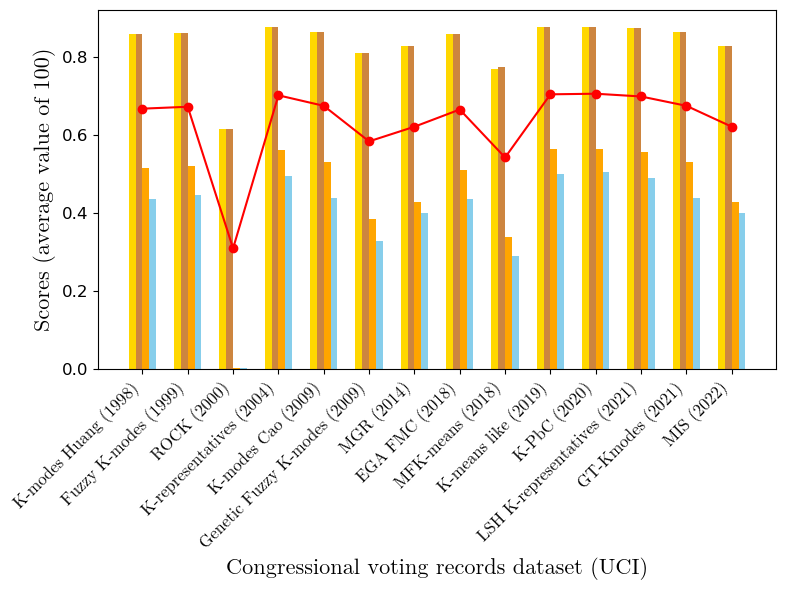

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Path to your font file
font_path = 'lmroman10-regular.otf'
font_prop = font_manager.FontProperties(fname=font_path)

# Define a larger font size for various elements
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
bar_label_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Read the data from CSV
df = pd.read_csv('_output_Voting/average_metrics_all_algorithms.csv')

# Extract algorithms and metrics
algorithms = df.iloc[:, 0].tolist()  # The first column contains the algorithm names
metrics = df.columns[1:].tolist()    # The rest of the columns are metrics

# Extract values (skip the first column which is the algorithm names)
values = df.iloc[:, 1:].values

# Calculate the average of the four metrics for each algorithm
averages = values.mean(axis=1)

# Set up bar plot
x = np.arange(len(algorithms))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['gold', 'peru', 'orange', 'skyblue']  # Colors for each metric

# Create bars for each metric
bars = []
for i in range(len(metrics)):
    bar = ax.bar(x + i * width, values[:, i], width, label=metrics[i], color=colors[i])
    bars.append(bar)

# Add line plot for the average values
# Adjust the x positions so that the average line passes between the second and third bars
average_x_positions = x + 1.5 * width
ax.plot(average_x_positions, averages, color='red', marker='o', linestyle='-', label='Average Score')

# Set labels and ticks
ax.set_ylabel('Scores (average value of 100)', fontproperties=large_font_prop)
ax.set_xlabel('Congressional voting records dataset (UCI)', fontproperties=large_font_prop)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(algorithms, fontproperties=bar_label_font_prop, rotation=45, ha="right")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add legend
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5, prop=large_font_prop)

# Adjust layout
fig.tight_layout()

# Save the plot as PDF with high quality
plt.savefig('clustering_performances_voting.pdf', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

#### Performance comparison on Mushroom dataset

In [14]:
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from MGR_algo import mgr
from EGA_FMC_algo import ega_fmc
from MIS_algo import clustering
from LSHkRepresentatives.LSHkRepresentatives import LSHkRepresentatives
from MFKmeans_algo import mfk
from pyclustering.cluster.rock import rock
from Fuzzy_Kmodes_algo import fuzzy_kmodes
from Shapley_cat_algo import shapley_cat
from Krepresentatives_algo import KRepresentatives
from Kmeans_like_algo import kmeans_like
from KPbC_algo import k_PbC_clustering
import evaluation
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Load dataset
data = np.genfromtxt("datasets/mushroom.csv", delimiter=',', encoding='utf-8-sig', dtype='str')
x = data[:, :-1]
y = data[:, -1]
k = 2
x_df = pd.DataFrame(x)

# Function to run a single round of clustering with a specified algorithm
def run_clustering_algorithm(algo_name):
    if algo_name == 'KModes_Huang':
        model = KModes(n_clusters=k, init='Huang', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'KModes_Cao': # Cao, F., Liang, J., Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.
        model = KModes(n_clusters=k, init='Cao', verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'MGR':
        labels = mgr(x_df, k)
    elif algo_name == 'EGA_FMC':
        labels = ega_fmc(x, k)
    elif algo_name == 'MIS':
        _, labels, _, _ = clustering(x_df, k)
        labels = labels.astype(int)
    elif algo_name == 'LSH_kReps':
        kreps = LSHkRepresentatives(n_clusters=k, n_init=5)
        labels = kreps.fit(x)
    elif algo_name == 'MFKmeans':
        labels = mfk(x, k)
    elif algo_name == 'ROCK':
        le = LabelEncoder()
        x_encoded = x_df.apply(le.fit_transform)
        rock_instance = rock(x_encoded.to_numpy(dtype=int), eps=4, number_clusters=k)
        rock_instance.process()
        clusters = rock_instance.get_clusters()
        labels = [-1] * len(x_encoded)
        for cluster_label, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_label
        labels = np.array(labels)
    elif algo_name == 'Fuzzy_Kmodes':
        _, _, labels, _ = fuzzy_kmodes(X=x, initialCluster=[], n_clusters=k)
        labels -= 1
    elif algo_name == 'GT_Kmodes':
        data, cl_bigc, _ = shapley_cat(x_df, delta=0.5, P=x_df.shape[0])
        cl_bigc = cl_bigc[0:k]
        model = KModes(n_clusters=k, init=np.array(cl_bigc), n_init=100, verbose=0)
        labels = model.fit_predict(data)
    elif algo_name == 'K_representatives':
        model = KRepresentatives(n_clusters=k, init='random', n_init=100, verbose=0)
        labels = model.fit_predict(x)
    elif algo_name == 'K_means_like':
        labels = kmeans_like(x, n_clusters=k, init='random', n_init=10, verbose=0, use_global_attr_count=0, beta=8)
    elif algo_name == 'K_PbC':
        labels = k_PbC_clustering(x_df=x_df, k=k, min_support=0.6)
    else:
        raise ValueError("Algorithm not recognized.")
    
    return labels

# Metrics calculation
def calculate_metrics(labels, true_labels):
    accuracy = evaluation.accuracy(labels, true_labels)
    purity = evaluation.purity(labels, true_labels)
    ari = evaluation.rand(labels, true_labels)
    nmi = evaluation.nmi(labels, true_labels)
    return accuracy, purity, ari, nmi

# Run 100 rounds for each algorithm
algorithms = ['KModes_Huang', 'Fuzzy_Kmodes', 'ROCK', 'K_representatives',
              'KModes_Cao', 'MGR', 'MFKmeans', 'K_means_like', 'K_PbC', 'LSH_kReps', 'GT_Kmodes', 'MIS']

# Dictionary to store mean metrics for each algorithm
average_metrics = {}

for algo in algorithms:
    print(f"Processing {algo}...")
    results = []
    
    for _ in tqdm(range(100), desc=f'Running {algo}'):
        labels = run_clustering_algorithm(algo)
        metrics = calculate_metrics(labels, y)
        results.append(metrics)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=['Accuracy', 'Purity', 'ARI', 'NMI'])
    
    # Calculate mean and std
    mean_values = results_df.mean()
    std_values = results_df.std()

    # Save the mean metrics
    average_metrics[algo] = mean_values

    # Print the results in table format
    print("\nResults:")
    print(pd.DataFrame({
        'Metric': ['Accuracy', 'Purity', 'ARI', 'NMI'],
        'Average': mean_values.values,
        'Std': std_values.values
    }).to_string(index=False))

    # Save to Excel
    filename = f"_output_Mushroom/Algo_{algo}.xlsx"
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        results_df.to_excel(writer, sheet_name='Results', index=False)
        
        workbook  = writer.book
        worksheet = writer.sheets['Results']
        
        # Write Average and Std
        worksheet.write(len(results_df) + 1, 0, 'Average:')
        worksheet.write_row(len(results_df) + 2, 0, mean_values.values)
        
        worksheet.write(len(results_df) + 4, 0, 'Std:')
        worksheet.write_row(len(results_df) + 5, 0, std_values.values)

    print(f"Results saved to {filename}\n")


# Save average metrics to a CSV file
algo_names = ["K-modes Huang (1998)", "Fuzzy K-modes (1999)", "ROCK (2000)", "K-representatives (2004)",
              "K-modes Cao (2009)", "Genetic Fuzzy K-modes (2009)", "MGR (2014)", "EGA FMC (2018)", 
              "MFK-means (2018)", "K-PbC (2020)", "LSH K-representatives (2021)", 
              "GT-Kmodes (2021)", "MIS (2022)"]

# Prepare DataFrame with correct index and fill it with empty values
average_metrics_df = pd.DataFrame(index=algo_names, columns=["Accuracy", "Purity", "ARI", "NMI"])

# Fill the DataFrame with the calculated mean metrics
for algo, mean_values in average_metrics.items():
    algo_name = algo.replace('_', ' ').title().replace('Kmodes', 'K-modes').replace('Krep', 'K-rep')
    if algo_name in average_metrics_df.index:
        average_metrics_df.loc[algo_name] = mean_values

# Set empty values for "Genetic Fuzzy K-modes (2009)" and "EGA FMC (2018)"
average_metrics_df.loc["Genetic Fuzzy K-modes (2009)"] = [""] * 4
average_metrics_df.loc["EGA FMC (2018)"] = [""] * 4
average_metrics_df.loc["K-means like (2019)"] = [""] * 4

# Save the DataFrame to a CSV file
output_csv = "_output_Mushroom/average_metrics_all_algorithms.csv"
average_metrics_df.to_csv(output_csv, index=True)

print(f"Average metrics of all algorithms saved to {output_csv}")

Processing KModes_Huang...


Running KModes_Huang: 100%|██████████| 100/100 [31:27<00:00, 18.88s/it]



Results:
  Metric  Average      Std
Accuracy 0.886647 0.033032
  Purity 0.886647 0.033032
     ARI 0.602231 0.062993
     NMI 0.553837 0.058091
Results saved to _output_Mushroom/Algo_KModes_Huang.xlsx

Processing Fuzzy_Kmodes...


Running Fuzzy_Kmodes: 100%|██████████| 100/100 [17:21<00:00, 10.41s/it]



Results:
  Metric  Average      Std
Accuracy 0.710661 0.122334
  Purity 0.710681 0.122302
     ARI 0.236602 0.222130
     NMI 0.215121 0.205373
Results saved to _output_Mushroom/Algo_Fuzzy_Kmodes.xlsx

Processing ROCK...


Running ROCK:   1%|          | 1/100 [3:01:57<300:14:00, 10917.58s/it]

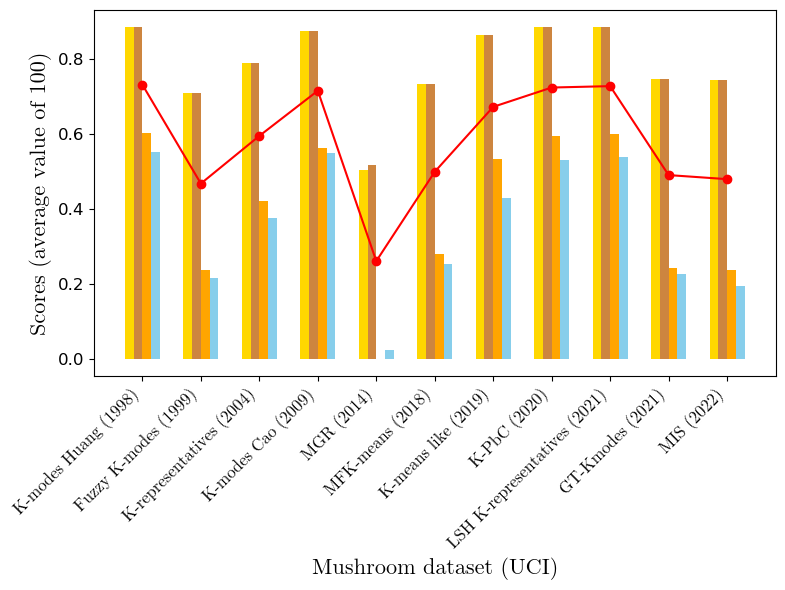

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Path to your font file
font_path = 'lmroman10-regular.otf'
font_prop = font_manager.FontProperties(fname=font_path)

# Define a larger font size for various elements
large_font_prop = font_manager.FontProperties(fname=font_path, size=16)
bar_label_font_prop = font_manager.FontProperties(fname=font_path, size=13)

# Read the data from CSV
df = pd.read_csv('_output_Mushroom/average_metrics_all_algorithms.csv')

# Extract algorithms and metrics
algorithms = df.iloc[:, 0].tolist()  # The first column contains the algorithm names
metrics = df.columns[1:].tolist()    # The rest of the columns are metrics

# Extract values (skip the first column which is the algorithm names)
values = df.iloc[:, 1:].values

# Calculate the average of the four metrics for each algorithm
averages = values.mean(axis=1)

# Set up bar plot
x = np.arange(len(algorithms))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['gold', 'peru', 'orange', 'skyblue']  # Colors for each metric

# Create bars for each metric
bars = []
for i in range(len(metrics)):
    bar = ax.bar(x + i * width, values[:, i], width, label=metrics[i], color=colors[i])
    bars.append(bar)

# Add line plot for the average values
# Adjust the x positions so that the average line passes between the second and third bars
average_x_positions = x + 1.5 * width
ax.plot(average_x_positions, averages, color='red', marker='o', linestyle='-', label='Average Score')

# Set labels and ticks
ax.set_ylabel('Scores (average value of 100)', fontproperties=large_font_prop)
ax.set_xlabel('Mushroom dataset (UCI)', fontproperties=large_font_prop)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(algorithms, fontproperties=bar_label_font_prop, rotation=45, ha="right")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add legend
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5, prop=large_font_prop)

# Adjust layout
fig.tight_layout()

# Save the plot as PDF with high quality
plt.savefig('clustering_performances_mushroom.pdf', dpi=300, bbox_inches='tight')

# Display plot
plt.show()